<a href="https://colab.research.google.com/github/andrea-parenti/wt-parenti/blob/master/HW1/DataAugmentationPre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
BASE_DIR = '/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1'

Mounted at /gdrive


# ⚙️ Import Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
import hashlib
from collections import defaultdict
import random

%matplotlib inline

# ⏳ Load the data

In [3]:
dataset_file_path = os.path.join(BASE_DIR, "dataset.npz")
data = np.load(dataset_file_path)
print("Keys: ", data.keys())
X = data["images"]
Y = data["labels"]
print("Data shape: ", X.shape)
print("Label shape: ", Y.shape)

Keys:  KeysView(NpzFile '/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/dataset.npz' with keys: images, labels)
Data shape:  (11959, 96, 96, 3)
Label shape:  (11959, 1)


# 🔎 Inspect Data

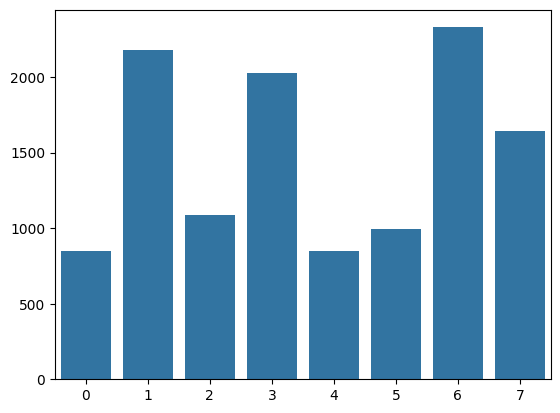

In [4]:
labels, counts = np.unique(Y, return_counts=True)

sns.barplot(x=labels, y=counts)
plt.show()

# 🔄 Process Data

## Divide et Impera

Maybe this can be done if I need to generate many data in an offline manner.

In [5]:
#unique_labels = np.unique(Y)
#print(X.shape)
#print(Y.shape)
#print(unique_labels.shape)

#Y_flat = Y.flatten()

#for idx, label in enumerate(unique_labels):
#  dataset_class_file_path = os.path.join(BASE_DIR, f"{label}.npz")
#  np.savez(dataset_class_file_path, images=X[Y_flat == label])

## Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.1),
    tfkl.RandomTranslation(height_factor=0.2, width_factor=0.2)
], name='Augmentation')

# Preprocess and augment function
def preprocess_and_augment(image, label):
    image = tf.image.resize(image, [96, 96])  # Resize images to target size
    image = tf.cast(image, tf.float32) / 255.0   # Normalize to [0, 1]
    image = data_augmentation(image)
    return image, label

def balance_classes(dataset, labels, counts, target_count):
    balanced_datasets = []

    for idx, label in enumerate(labels):
      class_data = dataset.filter(lambda img, lbl: tf.squeeze(lbl == label))
      if counts[idx] < target_count:
        repetitions = target_count // counts[idx]
        class_data = class_data.repeat(repetitions).map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
      else:
        class_data = class_data.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
      balanced_datasets.append(class_data)

    return tf.data.Dataset.sample_from_datasets(balanced_datasets)

Actually apply the augmentation defined above.

(33177, 96, 96, 3)
(33177, 1)


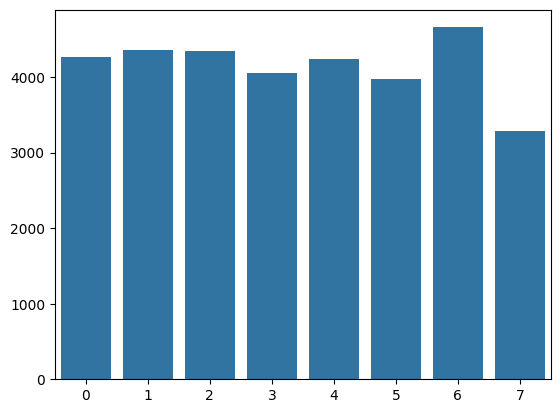

In [7]:
target_samples = max(counts)*2+1

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
balanced_dataset = balance_classes(dataset, labels, counts, target_samples)

X = []
Y = []

# Create a numpy iterator for the dataset
for image, label in balanced_dataset.as_numpy_iterator():
    X.append(image)
    Y.append(label)

# Convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

labels, counts = np.unique(Y, return_counts=True)

sns.barplot(x=labels, y=counts)
plt.show()

Verify the output of the preprocessing augmentation process and then print some samples

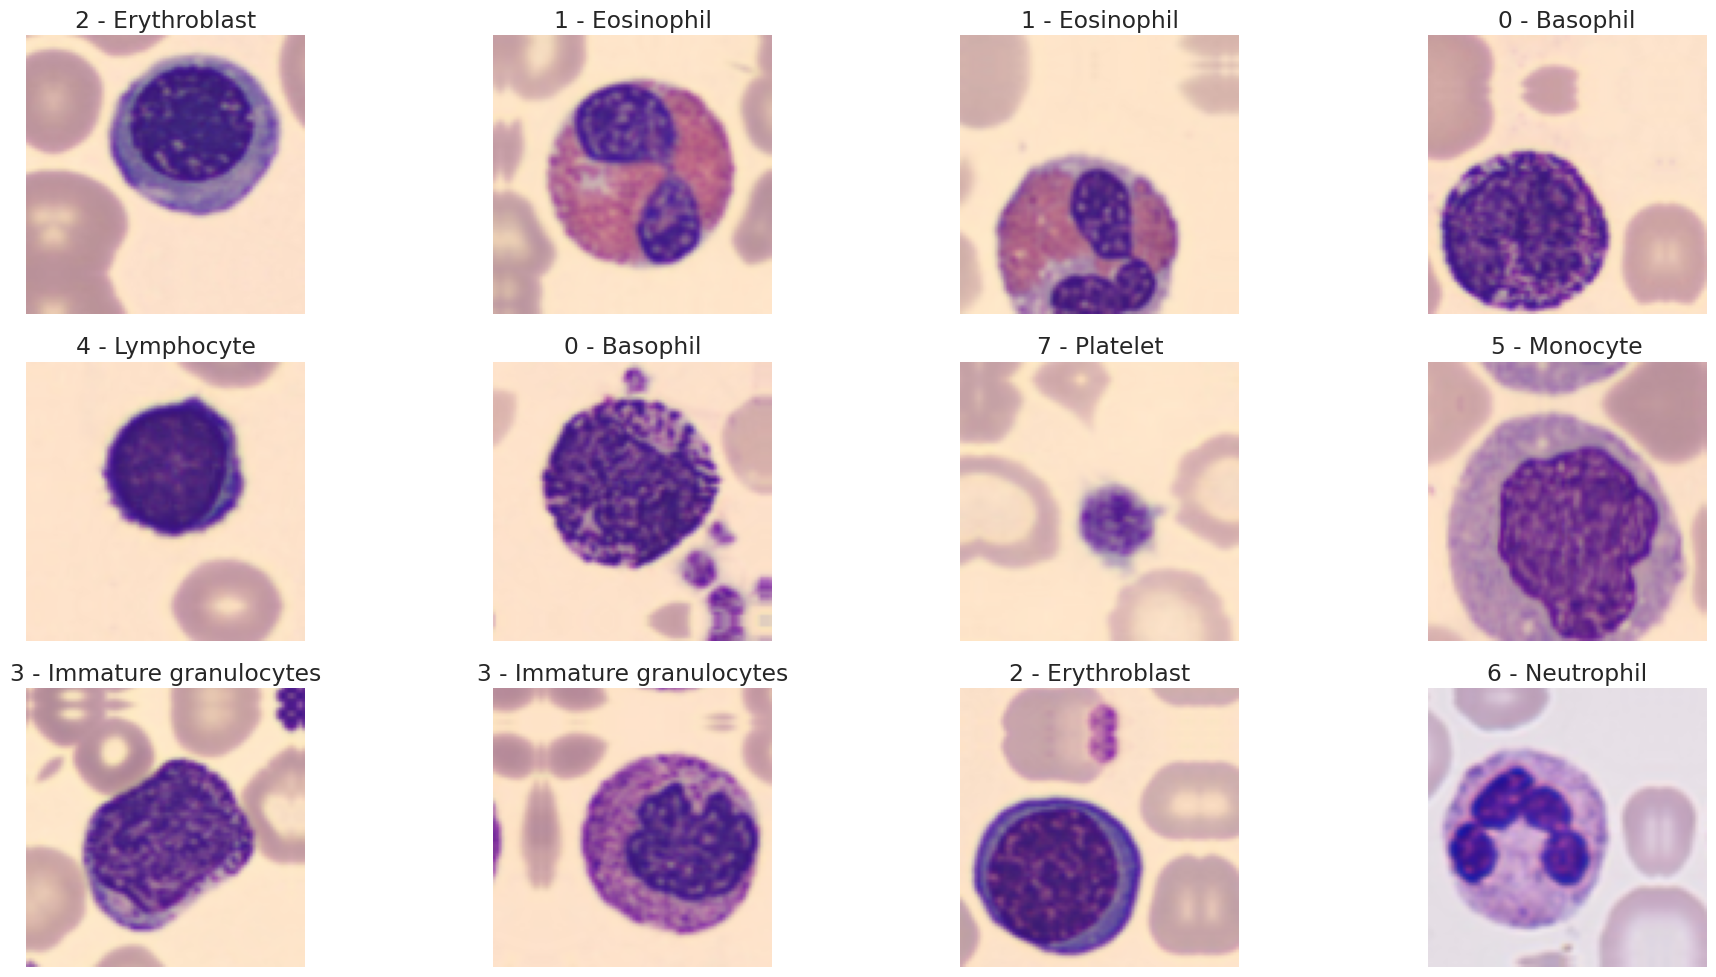

In [8]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

text_labels = ['Basophil',               # 0
               'Eosinophil',             # 1
               'Erythroblast',           # 2
               'Immature granulocytes',  # 3
               'Lymphocyte',             # 4
               'Monocyte',               # 5
               'Neutrophil',             # 6
               'Platelet']               # 7

# Display a sample of images from the training-validation dataset
num_img = 12
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(num_img // 4, 4, figsize=(20, 10))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i // 4, i % 4]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{Y[idx][0]} - {text_labels[Y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [9]:
dataset_file_path = os.path.join(BASE_DIR, "dataset_augmented.npz")

np.savez(dataset_file_path, images=X, labels=Y)